**CÁLCULO DE METRICAS Y GRAFICAS**

PREPARACIÓN DEL ENTORNO

In [ ]:
!pip install --quiet sacrebleu

import os, unicodedata
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sacrebleu
from google.colab import drive

# ---------- Config ----------
drive.mount("/content/drive", force_remount=True)
BASE = "/content/drive/MyDrive/tesis_IA_escritura"
EVAL_CSV = f"{BASE}/EVALUACIONES.csv"
TEXT_CSV = f"{BASE}/TEXTOS.csv"
OUT_DIR  = f"{BASE}/outputs"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
USE_HUMAN_AS_REF = True

LECTURA DE DATOS Y NORMALIZACION

In [ ]:
# ---------- Lectura robusta ----------
def read_csv_sc(path, expected_cols=None):
    df = pd.read_csv(
        path, sep=";", encoding="latin-1", engine="python",
        quotechar='"', doublequote=True, escapechar="\\",
        on_bad_lines="warn", keep_default_na=True
    )
    df.columns = [c.strip() for c in df.columns]
    if expected_cols:
        missing = [c for c in expected_cols if c not in df.columns]
        if missing:
            print("Faltan columnas en", os.path.basename(path), ":", missing)
    return df

df_eval  = read_csv_sc(EVAL_CSV, ["text_id","model","prompt_id","rater_id","coherence","style","surprise","bot_or_not"])
df_texts = read_csv_sc(TEXT_CSV, ["text_id","prompt_id","generated_text","reference_text"])

# ---------- Normalización ligera de texto ----------
def normalize_text(s: str) -> str:
    if pd.isna(s): return s
    s = str(s)
    s = unicodedata.normalize("NFC", s)
    for inv in ["\u00A0","\u200B","\u200C","\u200D","\u2028","\u202F","\u2060"]:
        s = s.replace(inv, " ")
    return " ".join(s.split())

for col in ["generated_text","reference_text"]:
    if col in df_texts.columns:
        df_texts[col] = df_texts[col].apply(normalize_text)

# ---------- Canon de modelos (igual que tu script) ----------
MODEL_CANON = {
    "GPT-5 mini": "ChatGPT",
    "ChatGPT": "ChatGPT", "chatgpt":"ChatGPT",
    "DeepSeek":"DeepSeek","deepseek":"DeepSeek",
    "Grok":"Grok","grok":"Grok",
    "flax-community/gpt-2-spanish":"flax-FT",
    "flax-community/gpt-2-spanish (FT)":"flax-FT",
    "Humano":"Humano","Human":"Humano"
}
def canon_model(x):
    s = str(x).strip()
    return MODEL_CANON.get(s, s)

df_eval["model"] = df_eval["model"].apply(canon_model)
if "model" in df_texts.columns:
    df_texts["model"] = df_texts["model"].apply(canon_model)

# Si TEXTOS no trae 'model', lo inferimos desde EVALUACIONES
def model_for_textid(text_id):
    m = df_eval.loc[df_eval["text_id"] == text_id, "model"]
    return canon_model(m.iloc[0]) if len(m) else None
if "model" not in df_texts.columns:
    df_texts["model"] = df_texts["text_id"].apply(model_for_textid)

# ---------- Agregados humanos por historia ----------
agg_funcs = {
    "coherence":"mean","style":"mean","surprise":"mean",
    "bot_or_not":"mean","rater_id":"count"
}
df_human = (df_eval.groupby(["text_id","prompt_id","model"], as_index=False)
                 .agg(agg_funcs)
                 .rename(columns={"rater_id":"n_ratings"}))
df_human["human_likeness"] = 1.0 - df_human["bot_or_not"]

# ---------- Unir master (TEXTOS + humanas) ----------
df_master = df_texts.merge(df_human, on=["text_id","prompt_id","model"], how="left", validate="one_to_one")

# ---------- distinct-1 y repetición ----------
def tokenize_space(text):
    if pd.isna(text): return []
    return str(text).split()

def distinct1(text):
    toks = tokenize_space(text)
    if not toks: return np.nan
    return len(set(toks))/len(toks)

df_master["distinct_1"] = df_master["generated_text"].apply(distinct1)
df_master["rep_uni"]    = 1.0 - df_master["distinct_1"]

CALCULO DE MÉTRICAS

In [ ]:
# ---------- Self-BLEU por prompt ----------
def self_bleu_for_group(gen_list, extra_refs=None):
    """
    gen_list: lista de textos generados del mismo prompt.
    extra_refs: lista de refs adicionales (p.ej. referencias humanas) o None.
    Devuelve lista de Self-BLEU en [0,1] por historia.
    """
    n = len(gen_list)
    scores = np.full(n, np.nan, dtype=float)
    # compila refs extra válidas
    extra_refs = [r for r in (extra_refs or []) if isinstance(r, str) and len(r)>0]
    for i in range(n):
        cand = gen_list[i]
        local_refs = [gen_list[j] for j in range(n) if j != i and isinstance(gen_list[j], str) and len(gen_list[j])>0]
        refs = local_refs + extra_refs
        if len(refs) == 0 or not isinstance(cand, str) or len(cand)==0:
            continue
        bleu = sacrebleu.corpus_bleu([cand], [refs], smooth_method="exp")  # BLEU en [0,100]
        scores[i] = bleu.score / 100.0
    return scores

df_master["self_bleu"] = np.nan
for pid, sub in df_master.groupby("prompt_id"):
    idx = sub.index
    gens = sub["generated_text"].fillna("").tolist()
    refs = []
    if USE_HUMAN_AS_REF and "reference_text" in sub.columns:
        refs = list(set([r for r in sub["reference_text"].dropna().tolist() if isinstance(r, str) and len(r)>0]))
    sb = self_bleu_for_group(gens, extra_refs=refs)
    df_master.loc[idx, "self_bleu"] = sb

# ---------- Humanas normalizadas y Creatividad_C ----------
def to_01_from_1to5(x): return (x - 1.0)/4.0

for c in ["coherence","style","surprise"]:
    if c in df_master.columns:
        df_master[c+"_norm"] = to_01_from_1to5(df_master[c]).clip(0,1)
df_master["human_likeness_norm"] = df_master["human_likeness"].clip(0,1)

hum_cols = [c for c in ["coherence_norm","style_norm","surprise_norm","human_likeness_norm"] if c in df_master.columns]
df_master["H_hum"] = df_master[hum_cols].mean(axis=1)

coh = df_master["coherence_norm"].fillna(0.0)
SB  = df_master["self_bleu"].clip(0,1)
R   = df_master["rep_uni"].clip(0,1)

df_master["Creatividad_C"] = (
    0.65*df_master["H_hum"] +
    0.20*(1.0 - SB)*coh +
    0.15*(1.0 - R)*coh
).clip(0,1)

# ---------- Guardar per-texto ----------
cols_order = ["text_id","prompt_id","model",
              "generated_text","reference_text",
              "coherence","style","surprise","human_likeness","n_ratings",
              "coherence_norm","style_norm","surprise_norm","human_likeness_norm",
              "distinct_1","rep_uni","self_bleu","H_hum","Creatividad_C"]
df_out = df_master[[c for c in cols_order if c in df_master.columns]].copy()

per_text_path = f"{OUT_DIR}/creatividad_selfbleu_per_texto.csv"
df_out.to_csv(per_text_path, index=False, encoding="utf-8")
print("✅ Guardado per-texto:", per_text_path)

# ---------- Agregados por modelo ----------
agg_model = (df_master.groupby("model", dropna=False)["Creatividad_C"]
             .agg(["mean","median","count"])
             .sort_values("mean", ascending=False))
agg_model_path = f"{OUT_DIR}/creatividad_selfbleu_por_modelo.csv"
agg_model.to_csv(agg_model_path, encoding="utf-8")
print("✅ Guardado por modelo:", agg_model_path)
print("\nResumen por modelo:\n", agg_model.round(3))

# ---------- Covarianza y correlación ----------
vars_cov = [v for v in ["coherence_norm","style_norm","surprise_norm","human_likeness_norm",
                        "distinct_1","rep_uni","self_bleu","H_hum","Creatividad_C"] if v in df_master.columns]
cov_mx  = df_master[vars_cov].cov()
corr_sp = df_master[vars_cov].corr(method="spearman")

cov_path  = f"{OUT_DIR}/covarianza_creatividad.csv"
corr_path = f"{OUT_DIR}/correlacion_spearman_creatividad.csv"
cov_mx.to_csv(cov_path, encoding="utf-8")
corr_sp.to_csv(corr_path, encoding="utf-8")
print("✅ Covarianza ->", cov_path)
print("✅ Spearman  ->", corr_path)

PREPARACIÓN DE GRÁFICAS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.6 MB/s eta 0:00:00
Mounted at /content/drive
✅ Guardado per-texto: /content/drive/MyDrive/tesis_IA_escritura/outputs/creatividad_selfbleu_per_texto.csv
✅ Guardado por modelo: /content/drive/MyDrive/tesis_IA_escritura/outputs/creatividad_selfbleu_por_modelo.csv

Resumen por modelo:
                                mean  median  count
model                                             
humano                        0.682   0.637     16
DeepSeek-V3                   0.674   0.677     16
ChatGPT                       0.648   0.622     16
Grok 4                        0.625   0.618     16
flax-community/gpt-2-spanisH  0.283   0.298     16
✅ Covarianza -> /content/drive/MyDrive/tesis_IA_escritura/outputs/covarianza_creatividad.csv
✅ Spearman  -> /content/drive/MyDrive/tesis_IA_escritura/outputs/correlacion_spearman_creatividad.csv


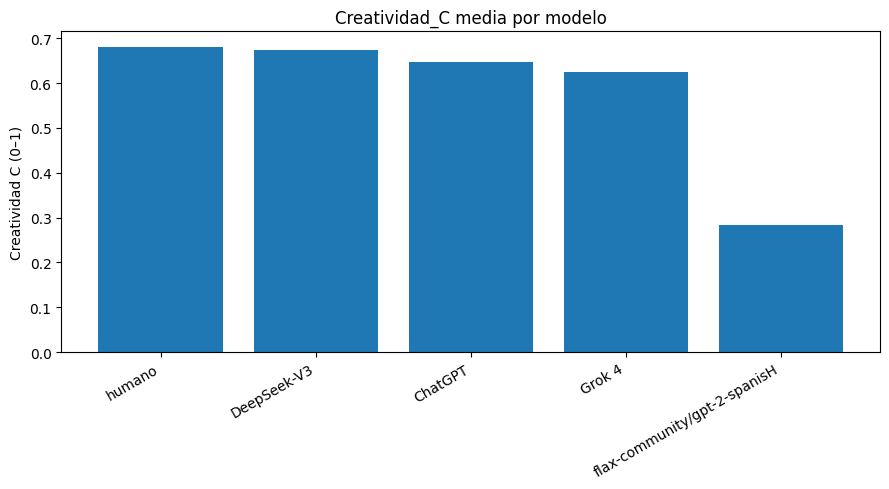

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_C_por_modelo.png


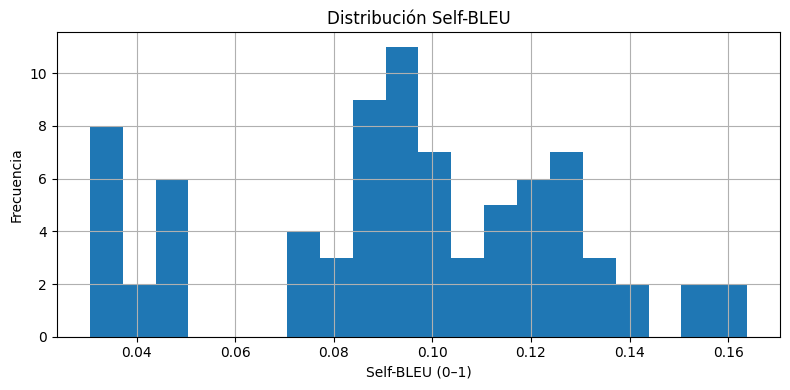

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_hist_selfbleu.png


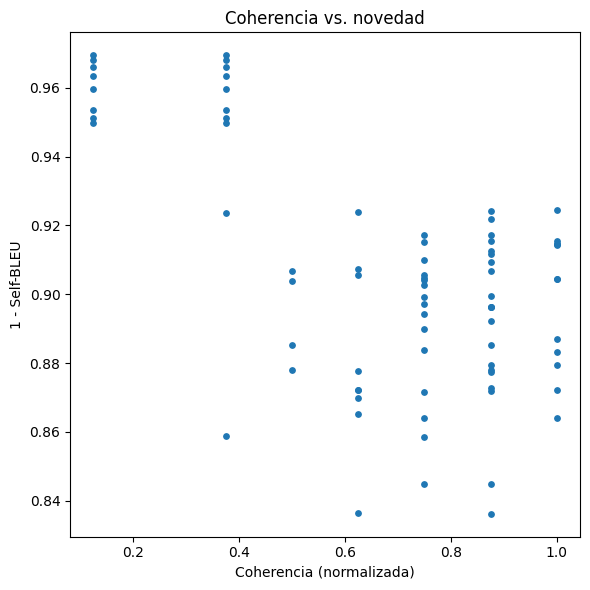

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_scatter_coh_vs_novedad.png

✅ Proceso completado. Revisa la carpeta 'outputs/'.


In [ ]:
# ---------- Figuras ----------
plt.figure(figsize=(9,5))
plt.bar(agg_model.index.astype(str), agg_model["mean"])
plt.xticks(rotation=30, ha='right'); plt.ylabel("Creatividad C (0–1)")
plt.title("Creatividad_C media por modelo"); plt.tight_layout()
fig1 = f"{OUT_DIR}/fig_C_por_modelo.png"
plt.savefig(fig1, dpi=150, bbox_inches="tight"); plt.show()
print("📊", fig1)

plt.figure(figsize=(8,4))
df_master["self_bleu"].dropna().hist(bins=20)
plt.xlabel("Self-BLEU (0–1)"); plt.ylabel("Frecuencia")
plt.title("Distribución Self-BLEU"); plt.tight_layout()
fig2 = f"{OUT_DIR}/fig_hist_selfbleu.png"
plt.savefig(fig2, dpi=150, bbox_inches="tight"); plt.show()
print("📊", fig2)

plt.figure(figsize=(6,6))
plt.scatter(df_master["coherence_norm"], 1.0 - df_master["self_bleu"], s=15)
plt.xlabel("Coherencia (normalizada)"); plt.ylabel("1 - Self-BLEU")
plt.title("Coherencia vs. novedad"); plt.tight_layout()
fig3 = f"{OUT_DIR}/fig_scatter_coh_vs_novedad.png"
plt.savefig(fig3, dpi=150, bbox_inches="tight"); plt.show()
print("📊", fig3)

print("\n✅ Proceso completado. Revisa la carpeta 'outputs/'.")


PREPARAR RESULTADOS CON INTERVALOS

Mounted at /content/drive
Leído: /content/drive/MyDrive/tesis_IA_escritura/outputs/creatividad_selfbleu_per_texto.csv -> (80, 19)
💾 /content/drive/MyDrive/tesis_IA_escritura/outputs/agg_Creatividad_C_por_modelo.csv


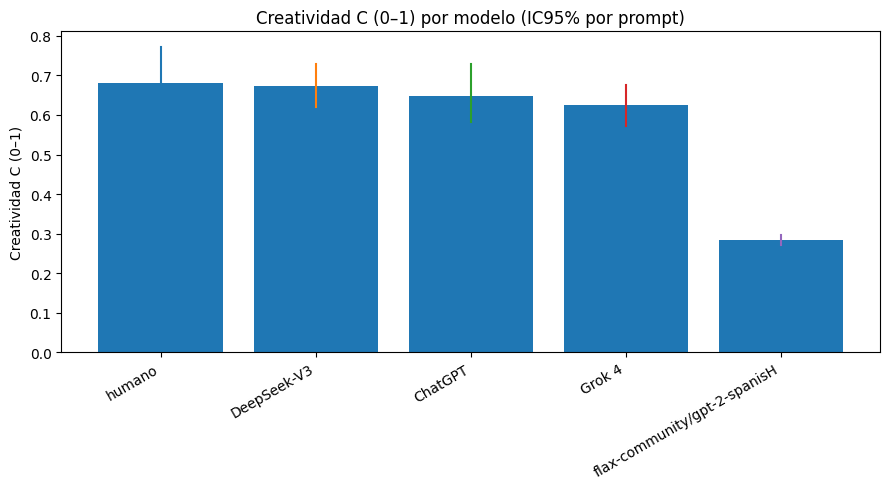

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_C_por_modelo_CI.png
💾 /content/drive/MyDrive/tesis_IA_escritura/outputs/agg_coherence_por_modelo.csv


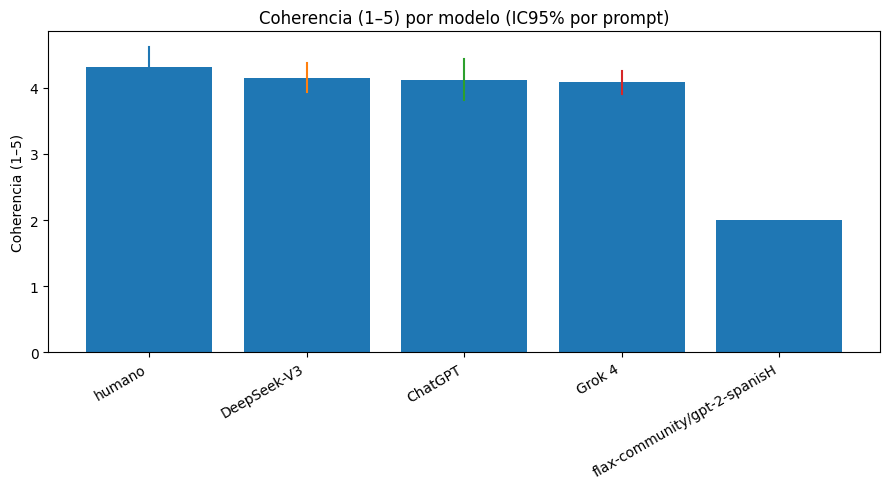

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_coherencia_CI.png
💾 /content/drive/MyDrive/tesis_IA_escritura/outputs/agg_style_por_modelo.csv


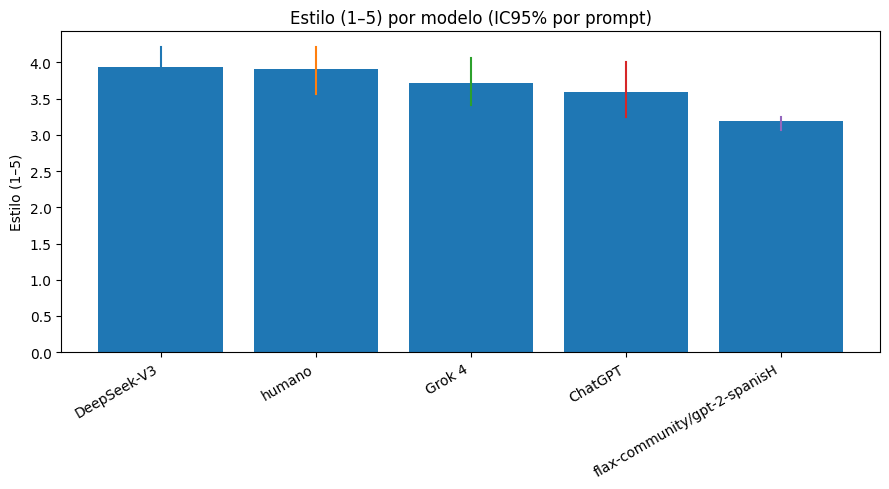

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_estilo_CI.png
💾 /content/drive/MyDrive/tesis_IA_escritura/outputs/agg_surprise_por_modelo.csv


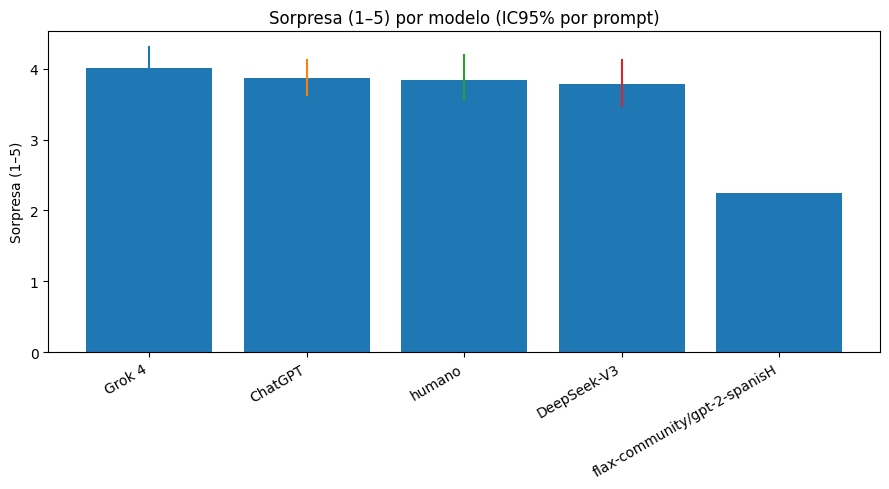

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_sorpresa_CI.png
💾 /content/drive/MyDrive/tesis_IA_escritura/outputs/agg_human_likeness_por_modelo.csv


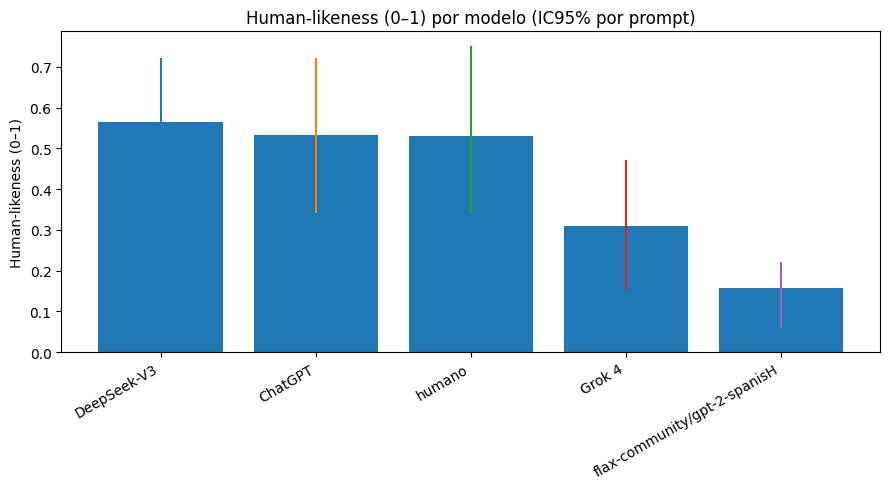

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_humanlikeness_CI.png
💾 /content/drive/MyDrive/tesis_IA_escritura/outputs/agg_novedad_por_modelo.csv


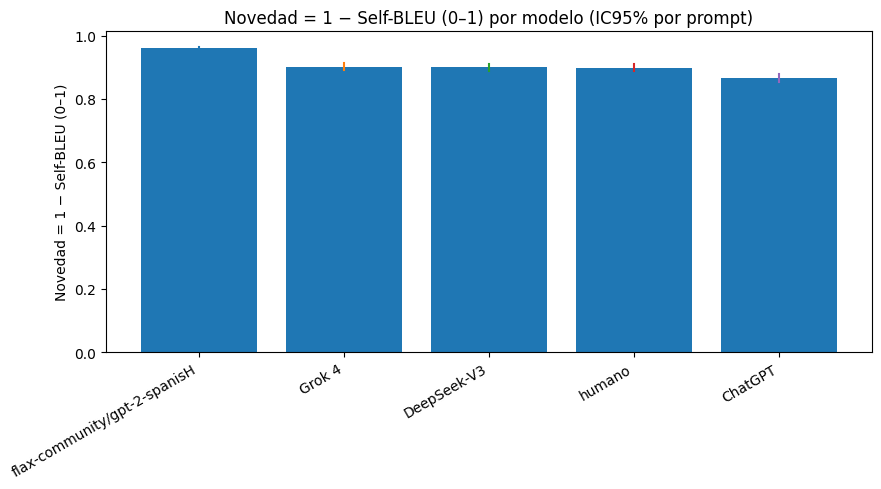

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_novedad_CI.png
💾 /content/drive/MyDrive/tesis_IA_escritura/outputs/agg_anti_rep_por_modelo.csv


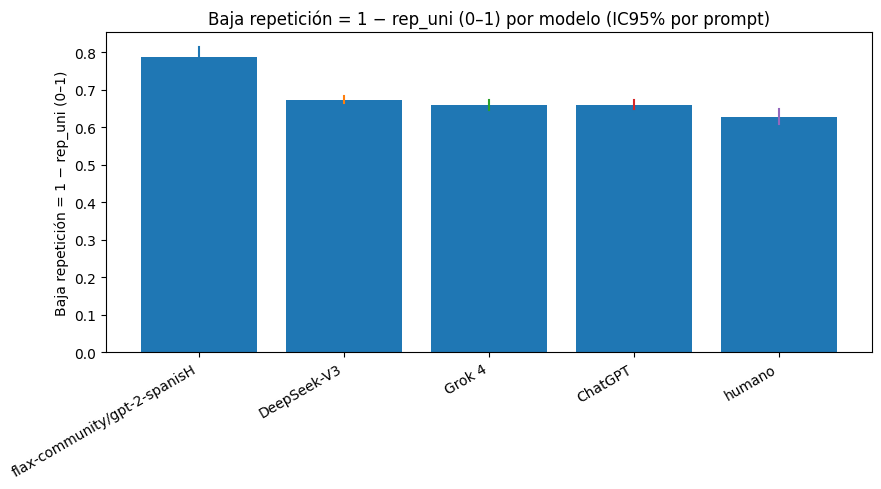

📊 /content/drive/MyDrive/tesis_IA_escritura/outputs/fig_antirep_CI.png


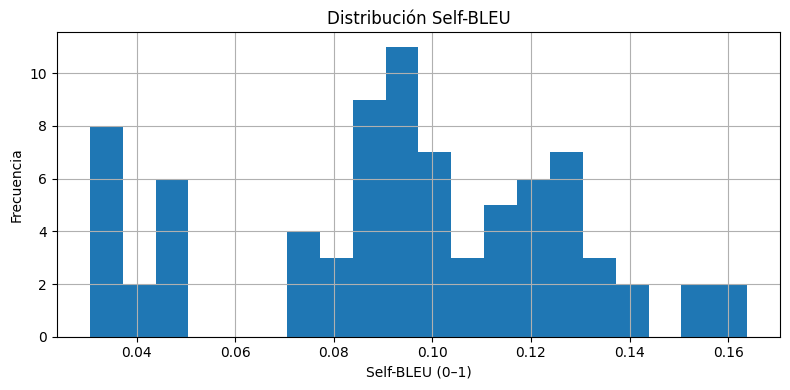

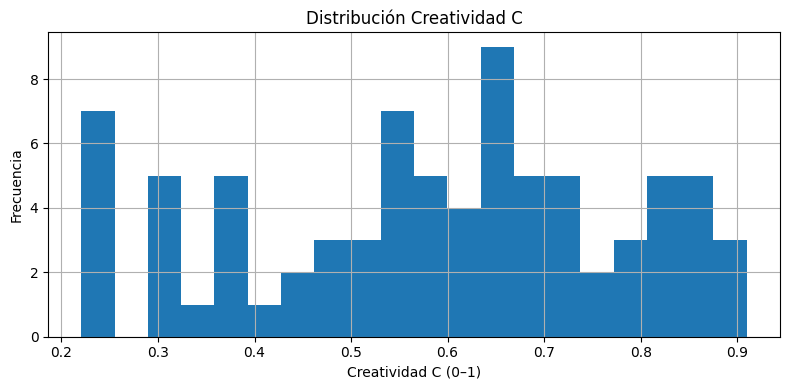

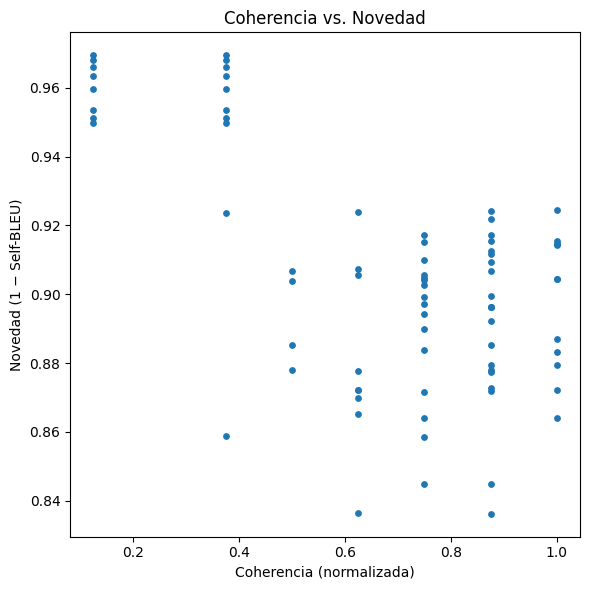


✅ Listo. Revisa los CSV y PNG en: /content/drive/MyDrive/tesis_IA_escritura/outputs


In [ ]:


import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# ---------- Config ----------
drive.mount("/content/drive", force_remount=True)
BASE   = "/content/drive/MyDrive/tesis_IA_escritura"
IN_CSV = f"{BASE}/outputs/creatividad_selfbleu_per_texto.csv"
OUT    = f"{BASE}/outputs"
Path(OUT).mkdir(parents=True, exist_ok=True)

# ---------- Carga ----------
df = pd.read_csv(IN_CSV, encoding="utf-8")
print("Leído:", IN_CSV, "->", df.shape)
req_cols = {"text_id","prompt_id","model","Creatividad_C",
            "coherence","style","surprise","human_likeness",
            "self_bleu","rep_uni"}
missing = req_cols - set(df.columns)
if missing:
    print("⚠️ Faltan columnas:", missing)

# ---------- Derivadas útiles ----------
df["novedad"] = 1.0 - df["self_bleu"].clip(0,1)     # mayor = más distinta a otras del mismo prompt
df["anti_rep"] = 1.0 - df["rep_uni"].clip(0,1)      # mayor = menos repetición
# Normalizadas humanas (por si las quieres en 0–1 para comparables)
def to_01_from_1to5(x): return (x - 1.0)/4.0
df["coherence_norm"] = to_01_from_1to5(df["coherence"]).clip(0,1)
df["style_norm"]     = to_01_from_1to5(df["style"]).clip(0,1)
df["surprise_norm"]  = to_01_from_1to5(df["surprise"]).clip(0,1)

# ---------- Utilidades de bootstrap estratificado por prompt ----------
rng = np.random.default_rng(42)

def prompt_means_by_model(df, metric):
    """
    Devuelve dict: model -> Serie (index=prompt_id, values=media por prompt del metric).
    Así comparamos modelos controlando la dificultad del prompt.
    """
    # media del metric por (prompt, model)
    g = (df.groupby(["prompt_id","model"], dropna=False)[metric]
            .mean().reset_index())
    # separa por modelo a series con índice prompt
    out = {}
    for m, sub in g.groupby("model", dropna=False):
        s = sub.set_index("prompt_id")[metric].dropna()
        out[m] = s
    return out

def bootstrap_ci_prompt(series, B=2000, alpha=0.05):
    """
    IC bootstrap sobre la media, re-muestreando prompts con reemplazo.
    series: Serie indexada por prompt_id (valores = media por prompt)
    """
    arr = series.values
    n = len(arr)
    if n == 0:
        return np.nan, np.nan, np.nan, 0
    if n == 1:
        m = float(arr[0])
        return m, m, m, 1
    boots = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        boots.append(np.mean(arr[idx]))
    boots = np.array(boots, dtype=float)
    mean = float(np.mean(boots))
    lo   = float(np.quantile(boots, alpha/2))
    hi   = float(np.quantile(boots, 1 - alpha/2))
    return mean, lo, hi, n

def aggregate_with_ci(df, metric, B=2000):
    """
    Tabla con media e IC95% por modelo (estratificado por prompt).
    Incluye n_prompts (nº de prompts con datos para ese modelo) y n_texts.
    """
    pm = prompt_means_by_model(df, metric)
    rows = []
    for model, ser in pm.items():
        mean, lo, hi, n_prompts = bootstrap_ci_prompt(ser, B=B)
        n_texts = df[df["model"]==model][metric].notna().sum()
        rows.append({
            "model": model,
            f"{metric}_mean": mean,
            f"{metric}_ci_lo": lo,
            f"{metric}_ci_hi": hi,
            "n_prompts": int(n_prompts),
            "n_texts": int(n_texts)
        })
    out = pd.DataFrame(rows).sort_values(f"{metric}_mean", ascending=False)
    return out

def plot_bar_ci(tab, metric, title, ylabel, filename):
    """
    Gráfica de barras con IC95% (error bars). tab viene de aggregate_with_ci.
    """
    if tab.empty:
        print("Sin datos para", metric)
        return
    x = tab["model"].astype(str).values
    y = tab[f"{metric}_mean"].values
    lo = tab[f"{metric}_ci_lo"].values
    hi = tab[f"{metric}_ci_hi"].values
    yerr = np.vstack([y - lo, hi - y])

    plt.figure(figsize=(9,5))
    plt.bar(x, y)
    # error bars manuales:
    for i in range(len(x)):
        plt.plot([i, i], [lo[i], hi[i]])
    plt.xticks(rotation=30, ha='right')
    plt.ylabel(ylabel); plt.title(title)
    plt.tight_layout()
    path = f"{OUT}/{filename}"
    plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show()
    print("📊", path)

# ---------- Lista de métricas a reportar ----------
metrics_plan = [
    ("Creatividad_C", "Creatividad C (0–1)", "fig_C_por_modelo_CI.png"),
    ("coherence",     "Coherencia (1–5)",    "fig_coherencia_CI.png"),
    ("style",         "Estilo (1–5)",        "fig_estilo_CI.png"),
    ("surprise",      "Sorpresa (1–5)",      "fig_sorpresa_CI.png"),
    ("human_likeness","Human-likeness (0–1)","fig_humanlikeness_CI.png"),
    ("novedad",       "Novedad = 1 − Self-BLEU (0–1)", "fig_novedad_CI.png"),
    ("anti_rep",      "Baja repetición = 1 − rep_uni (0–1)", "fig_antirep_CI.png"),
]

# ---------- Agregación + figuras ----------
all_tabs = {}
for metric, nice_label, fig_name in metrics_plan:
    tab = aggregate_with_ci(df, metric, B=2000)
    all_tabs[metric] = tab
    csv_path = f"{OUT}/agg_{metric}_por_modelo.csv"
    tab.to_csv(csv_path, index=False, encoding="utf-8")
    print("💾", csv_path)
    plot_bar_ci(tab, metric, f"{nice_label} por modelo (IC95% por prompt)", nice_label, fig_name)

# ---------- Histogramas y dispersión (extras útiles) ----------
# Histograma de Self-BLEU y Creatividad_C
plt.figure(figsize=(8,4))
df["self_bleu"].dropna().hist(bins=20)
plt.xlabel("Self-BLEU (0–1)"); plt.ylabel("Frecuencia")
plt.title("Distribución Self-BLEU"); plt.tight_layout()
plt.savefig(f"{OUT}/fig_hist_selfbleu.png", dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(8,4))
df["Creatividad_C"].dropna().hist(bins=20)
plt.xlabel("Creatividad C (0–1)"); plt.ylabel("Frecuencia")
plt.title("Distribución Creatividad C"); plt.tight_layout()
plt.savefig(f"{OUT}/fig_hist_C.png", dpi=150, bbox_inches="tight"); plt.show()

# Dispersión: coherencia vs novedad
plt.figure(figsize=(6,6))
plt.scatter(df["coherence_norm"], df["novedad"], s=15)
plt.xlabel("Coherencia (normalizada)"); plt.ylabel("Novedad (1 − Self-BLEU)")
plt.title("Coherencia vs. Novedad"); plt.tight_layout()
plt.savefig(f"{OUT}/fig_scatter_coh_vs_novedad.png", dpi=150, bbox_inches="tight"); plt.show()

print("\n✅ Listo. Revisa los CSV y PNG en:", OUT)
